RBI Strategy - Introduced by Oliver Velez, Perfected by Akbar Pathan

Importing necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import os
import re
import warnings

/Users/akbarpathan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Downloading 2min price data of SPY & all tickers in the S&P500

In [2]:
# Fetch the list of S&P 500 tickers
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Initialize an empty dictionary to store the data
data = {}

# Define the "Stock Data" directory
stock_data_folder = os.path.join(os.getcwd(), "Stock Data")

# Create the "Stock Data" directory if it doesn't exist
if not os.path.exists(stock_data_folder):
    os.makedirs(stock_data_folder)

# Retrieve 2-minute interval data for the past 60 days
start_date = (datetime.datetime.now() - datetime.timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

for ticker in sp500_tickers:
    #print(f"Fetching data for {ticker}...")
    try:
        # Fetch the 2-minute interval data with quiet=True to suppress the progress bar
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='2m', progress=False)
        data[ticker] = stock_data
        
        # Save the stock data into a CSV file inside the "Stock Data" folder
        stock_data.to_csv(os.path.join(stock_data_folder, f"{ticker}_2min_data.csv"))
        
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

print("Data retrieval and saving complete!")


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (2m 2024-07-16 -> 2024-09-13)')


Data retrieval and saving complete!


Adding 20min & 200min SMA data to each 2min Data file

In [3]:
# Get the current working directory
base_directory = os.getcwd()

# Define the path to the "Stock Data" directory
stock_data_directory = os.path.join(base_directory, "Stock Data")

# List all CSV files in the "Stock Data" directory
csv_files = [f for f in os.listdir(stock_data_directory) if f.endswith('_2min_data.csv')]

# Loop through each CSV file in the "Stock Data" directory
for csv_file in csv_files:
    # Extract the ticker name by removing the "_2min_data.csv" part
    ticker = csv_file.replace('_2min_data.csv', '')

    # Define the full file path for the CSV file
    file_path = os.path.join(stock_data_directory, csv_file)
    
    # Check if the CSV file exists (extra precaution)
    if os.path.exists(file_path):
        print(f"Processing data for {ticker}...")
        
        # Load the previously saved data
        stock_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Check the first few rows of the data to ensure it loaded correctly
        print(f"Initial data check for {ticker}:")
        print(stock_data.head())
        
        # Calculate the 20-minute and 200-minute SMAs
        stock_data['20min_SMA'] = stock_data['Close'].rolling(window=10).mean()  # 20min SMA on a 2min interval is a 10-period SMA
        stock_data['200min_SMA'] = stock_data['Close'].rolling(window=100).mean()  # 200min SMA on a 2min interval is a 100-period SMA
        
        # Check if the SMA columns are populated correctly
        if stock_data['20min_SMA'].isnull().all() or stock_data['200min_SMA'].isnull().all():
            print(f"Error: SMA columns are not populated correctly for {ticker}. Please check the calculations.")
        else:
            print(f"SMA columns populated successfully for {ticker}. Sample data:")
            print(stock_data[['20min_SMA', '200min_SMA']].dropna().head())
        
        # Save the updated data with SMAs back to the same CSV file
        stock_data.to_csv(file_path)
        
        print(f"Process completed successfully for {ticker}! 20min & 200min SMA data added to CSV file.\n")
    else:
        print(f"CSV file for {ticker} does not exist. Skipping...")

print("All files processed successfully!")

Processing data for MS...
Initial data check for MS:
                                 Open        High         Low       Close  \
Datetime                                                                    
2024-07-26 09:30:00-04:00  104.860001  105.070000  104.639999  104.919998   
2024-07-26 09:32:00-04:00  104.919998  105.379997  104.845001  105.309998   
2024-07-26 09:34:00-04:00  105.214996  105.214996  105.000000  105.050003   
2024-07-26 09:36:00-04:00  105.029999  105.220001  104.980003  105.040001   
2024-07-26 09:38:00-04:00  105.059998  105.260002  105.000000  105.239998   

                            Adj Close  Volume  
Datetime                                       
2024-07-26 09:30:00-04:00  104.919998  115938  
2024-07-26 09:32:00-04:00  105.309998   76230  
2024-07-26 09:34:00-04:00  105.050003   27627  
2024-07-26 09:36:00-04:00  105.040001   32891  
2024-07-26 09:38:00-04:00  105.239998   30483  
SMA columns populated successfully for MS. Sample data:
               

Adding column to check if setup for the strategy (Picture of Power) is 'activated' at each time

In [4]:
# Get the current working directory
base_directory = os.getcwd()

# Define the path to the "Stock Data" directory
stock_data_directory = os.path.join(base_directory, "Stock Data")

# List all CSV files in the "Stock Data" directory
csv_files = [f for f in os.listdir(stock_data_directory) if f.endswith('_2min_data.csv')]

# Loop through each CSV file in the "Stock Data" directory
for csv_file in csv_files:
    # Extract the ticker name by removing the "_2min_data.csv" part
    ticker = csv_file.replace('_2min_data.csv', '')

    # Define the full file path for the CSV file
    file_path = os.path.join(stock_data_directory, csv_file)
    
    # Check if the CSV file exists (extra precaution)
    if os.path.exists(file_path):
        print(f"Processing data for {ticker}...")
        
        # Load the previously saved data (with the SMAs already calculated)
        stock_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Now add the Setup condition
        stock_data['Setup'] = stock_data['20min_SMA'] > stock_data['200min_SMA']
        
        # Save the updated data with the Setup column to the same CSV file
        stock_data.to_csv(file_path)
        
        # Re-load the final file to confirm everything saved correctly
        final_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Check if the SMA and Setup columns are populated in the final CSV
        if final_data[['20min_SMA', '200min_SMA', 'Setup']].isnull().all().any():
            print(f"Error: One or more columns (SMA, Setup) are not populated correctly for {ticker}.")
        else:
            print(f"Final CSV file saved correctly for {ticker}. Sample data:")
            print(final_data[['20min_SMA', '200min_SMA', 'Setup']].dropna().head())
        
        print(f"Process completed successfully for {ticker}!")
    else:
        print(f"CSV file for {ticker} does not exist. Skipping...")

print("All files processed successfully!")


Processing data for MS...
Final CSV file saved correctly for MS. Sample data:
                            20min_SMA  200min_SMA  Setup
Datetime                                                
2024-07-26 12:50:00-04:00  105.226111  105.325355  False
2024-07-26 12:52:00-04:00  105.242110  105.329655  False
2024-07-26 12:54:00-04:00  105.269110  105.330755  False
2024-07-26 12:56:00-04:00  105.296111  105.334355  False
2024-07-26 12:58:00-04:00  105.322610  105.338305  False
Process completed successfully for MS!
Processing data for SPG...
Final CSV file saved correctly for SPG. Sample data:
                            20min_SMA  200min_SMA  Setup
Datetime                                                
2024-07-26 12:50:00-04:00  152.147000  151.605677   True
2024-07-26 12:52:00-04:00  152.155501  151.625229   True
2024-07-26 12:54:00-04:00  152.165001  151.639328   True
2024-07-26 12:56:00-04:00  152.185501  151.656978   True
2024-07-26 12:58:00-04:00  152.199001  151.670728   True
Proce

Identifying & Labeling each candlestick appropriately

In [5]:
# Get the current working directory
base_directory = os.getcwd()

# Define the path to the "Stock Data" directory
stock_data_directory = os.path.join(base_directory, "Stock Data")

# List all CSV files in the "Stock Data" directory
csv_files = [f for f in os.listdir(stock_data_directory) if f.endswith('_2min_data.csv')]

# Loop through each CSV file in the "Stock Data" directory
for csv_file in csv_files:
    # Extract the ticker name by removing the "_2min_data.csv" part
    ticker = csv_file.replace('_2min_data.csv', '')

    # Define the full file path for the CSV file
    file_path = os.path.join(stock_data_directory, csv_file)
    
    # Check if the CSV file exists (extra precaution)
    if os.path.exists(file_path):
        print(f"Processing data for {ticker}...")
        
        # Load the ticker data with SMAs and Setup
        stock_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Initialize all bars as "Noise Bar" by default
        stock_data['Label'] = "Noise Bar"
        
        # Identify Control Bars
        stock_data.loc[(stock_data['Close'] > stock_data['Open']) & (stock_data['Setup'] == True), 'Label'] = "Control Bar"
        
        # Iterate through the DataFrame to label Ignored Bars and Indicator Bars
        for i in range(1, len(stock_data) - 1):
            if stock_data.iloc[i]['Label'] == "Control Bar":
                # We have identified a Control Bar; now check subsequent bars

                # Check for Ignored Bar A
                if (stock_data.iloc[i + 1]['Close'] < stock_data.iloc[i + 1]['Open']) and \
                   ((stock_data.iloc[i + 1]['Open'] - stock_data.iloc[i + 1]['Close']) <= 0.5 * (stock_data.iloc[i]['Close'] - stock_data.iloc[i]['Open'])):
                    stock_data.iloc[i + 1, stock_data.columns.get_loc('Label')] = "Ignored Bar A"

                    # Check for Ignored Bar B
                    if (i + 2 < len(stock_data)) and \
                       (stock_data.iloc[i + 2]['Close'] < stock_data.iloc[i + 2]['Open']) and \
                       ((stock_data.iloc[i + 2]['Open'] - stock_data.iloc[i + 2]['Close']) <= 0.5 * (stock_data.iloc[i]['Close'] - stock_data.iloc[i]['Open'])):
                        stock_data.iloc[i + 2, stock_data.columns.get_loc('Label')] = "Ignored Bar B"
                        next_index = i + 2
                    else:
                        next_index = i + 1
                    
                    # Check for Indicator Bar
                    if (next_index + 1 < len(stock_data)) and \
                       (stock_data.iloc[next_index + 1]['Close'] > stock_data.iloc[next_index + 1]['Open']) and \
                       (stock_data.iloc[next_index + 1]['High'] > stock_data.iloc[next_index]['High']):
                        stock_data.iloc[next_index + 1, stock_data.columns.get_loc('Label')] = "Indicator Bar"

        # Final Review: Relabel any "Control Bar" that is not followed by an "Ignored Bar" as a "Noise Bar"
        for i in range(len(stock_data) - 1):
            if stock_data.iloc[i]['Label'] == "Control Bar":
                if stock_data.iloc[i + 1]['Label'] not in ["Ignored Bar A", "Ignored Bar B"]:
                    stock_data.iloc[i, stock_data.columns.get_loc('Label')] = "Noise Bar"

        # Save the labeled data to the same CSV file
        stock_data.to_csv(file_path)

        print(f"Candlestick labeling completed and saved successfully for {ticker}!\n")
    else:
        print(f"CSV file for {ticker} does not exist. Skipping...")

print("All files processed successfully!")


Processing data for MS...
Candlestick labeling completed and saved successfully for MS!

Processing data for SPG...
Candlestick labeling completed and saved successfully for SPG!

Processing data for WRB...
Candlestick labeling completed and saved successfully for WRB!

Processing data for MLM...
Candlestick labeling completed and saved successfully for MLM!

Processing data for BAC...
Candlestick labeling completed and saved successfully for BAC!

Processing data for AAPL...
Candlestick labeling completed and saved successfully for AAPL!

Processing data for APD...
Candlestick labeling completed and saved successfully for APD!

Processing data for EW...
Candlestick labeling completed and saved successfully for EW!

Processing data for ADP...
Candlestick labeling completed and saved successfully for ADP!

Processing data for SBAC...
Candlestick labeling completed and saved successfully for SBAC!

Processing data for GIS...
Candlestick labeling completed and saved successfully for GIS!


Checking if 20min SMA is 'close' to the current price & if 20min SMA's slope is positive. This piece of code also identitifes each point at which the data is ready for a trade.

In [6]:
# Get the current working directory
base_directory = os.getcwd()

# Define the path to the "Stock Data" directory
stock_data_directory = os.path.join(base_directory, "Stock Data")

# List all CSV files in the "Stock Data" directory
csv_files = [f for f in os.listdir(stock_data_directory) if f.endswith('_2min_data.csv')]

# Loop through each CSV file in the "Stock Data" directory
for csv_file in csv_files:
    # Extract the ticker name by removing the "_2min_data.csv" part
    ticker = csv_file.replace('_2min_data.csv', '')

    # Define the full file path for the CSV file
    file_path = os.path.join(stock_data_directory, csv_file)
    
    # Check if the CSV file exists (extra precaution)
    if os.path.exists(file_path):
        print(f"Processing data for {ticker}...")
        
        # Load the ticker data with final labels
        stock_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Calculate the slope (first derivative) of the 20-minute SMA
        stock_data['SMA_20_slope'] = stock_data['20min_SMA'].diff()
        
        # Initialize all bars as "Empty"
        stock_data['Trade_Status'] = "Empty"
        
        # Check the conditions after identifying Ignored Bars
        for i in range(len(stock_data) - 1):
            if stock_data.iloc[i]['Label'] in ["Ignored Bar A", "Ignored Bar B"]:
                # Condition 1: Check if the closing price is within $1.00 of the 20-minute SMA
                proximity_condition = abs(stock_data.iloc[i]['Close'] - stock_data.iloc[i]['20min_SMA']) <= 1.00
                
                # Condition 2: Check if the slope of the 20-minute SMA is positive
                slope_condition = stock_data.iloc[i]['SMA_20_slope'] > 0
                
                # If both conditions are true, label the bar as "Primed"
                if proximity_condition and slope_condition:
                    stock_data.iloc[i, stock_data.columns.get_loc('Trade_Status')] = "Primed"

        # Save the updated data with the Trade_Status column to the same CSV file
        stock_data.to_csv(file_path)

        print(f"Proximity and slope checks completed, and labels applied successfully for {ticker}!\n")
    else:
        print(f"CSV file for {ticker} does not exist. Skipping...")

print("All files processed successfully!")

Processing data for MS...
Proximity and slope checks completed, and labels applied successfully for MS!

Processing data for SPG...
Proximity and slope checks completed, and labels applied successfully for SPG!

Processing data for WRB...
Proximity and slope checks completed, and labels applied successfully for WRB!

Processing data for MLM...
Proximity and slope checks completed, and labels applied successfully for MLM!

Processing data for BAC...
Proximity and slope checks completed, and labels applied successfully for BAC!

Processing data for AAPL...
Proximity and slope checks completed, and labels applied successfully for AAPL!

Processing data for APD...
Proximity and slope checks completed, and labels applied successfully for APD!

Processing data for EW...
Proximity and slope checks completed, and labels applied successfully for EW!

Processing data for ADP...
Proximity and slope checks completed, and labels applied successfully for ADP!

Processing data for SBAC...
Proximity a

Cleaning all data by rounding values

In [7]:
# Get the current working directory
base_directory = os.getcwd()

# Define the path to the "Stock Data" directory
stock_data_directory = os.path.join(base_directory, "Stock Data")

# List all CSV files in the "Stock Data" directory
csv_files = [f for f in os.listdir(stock_data_directory) if f.endswith('_2min_data.csv')]

# Loop through each CSV file in the "Stock Data" directory
for csv_file in csv_files:
    # Extract the ticker name by removing the "_2min_data.csv" part
    ticker = csv_file.replace('_2min_data.csv', '')

    # Define the full file path for the CSV file
    file_path = os.path.join(stock_data_directory, csv_file)
    
    # Check if the CSV file exists (extra precaution)
    if os.path.exists(file_path):
        print(f"Processing data for {ticker}...")
        
        # Load the data from the CSV file
        stock_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Round all numerical values to the nearest thousandth and format to three decimal places
        for column in stock_data.select_dtypes(include=['float64', 'int64']).columns:
            stock_data[column] = stock_data[column].round(3).apply(lambda x: f"{x:.3f}")
        
        # Save the cleaned-up data back to the same CSV file
        stock_data.to_csv(file_path)

        print(f"{ticker}_2min_data.csv has been cleaned and saved successfully for {ticker}!\n")
    else:
        print(f"CSV file for {ticker} does not exist. Skipping...")

print("All files processed successfully!")

Processing data for MS...
MS_2min_data.csv has been cleaned and saved successfully for MS!

Processing data for SPG...
SPG_2min_data.csv has been cleaned and saved successfully for SPG!

Processing data for WRB...
WRB_2min_data.csv has been cleaned and saved successfully for WRB!

Processing data for MLM...
MLM_2min_data.csv has been cleaned and saved successfully for MLM!

Processing data for BAC...
BAC_2min_data.csv has been cleaned and saved successfully for BAC!

Processing data for AAPL...
AAPL_2min_data.csv has been cleaned and saved successfully for AAPL!

Processing data for APD...
APD_2min_data.csv has been cleaned and saved successfully for APD!

Processing data for EW...
EW_2min_data.csv has been cleaned and saved successfully for EW!

Processing data for ADP...
ADP_2min_data.csv has been cleaned and saved successfully for ADP!

Processing data for SBAC...
SBAC_2min_data.csv has been cleaned and saved successfully for SBAC!

Processing data for GIS...
GIS_2min_data.csv has b

Executing trades and saving data to Ticker's Trade Log

In [8]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Get the current working directory
base_directory = os.getcwd()

# Define the paths for the "Stock Data" and "Trade Logs" directories
stock_data_directory = os.path.join(base_directory, "Stock Data")
trade_logs_directory = os.path.join(base_directory, "Trade Logs")

# Ensure the "Trade Logs" directory exists
if not os.path.exists(trade_logs_directory):
    os.makedirs(trade_logs_directory)

# List all CSV files in the "Stock Data" directory
csv_files = [f for f in os.listdir(stock_data_directory) if f.endswith('_2min_data.csv')]

# Loop through each CSV file in the "Stock Data" directory
for csv_file in csv_files:
    # Extract the ticker name by removing the "_2min_data.csv" part
    ticker = csv_file.replace('_2min_data.csv', '')

    # Define the full file paths for the CSV files
    data_file_path = os.path.join(stock_data_directory, csv_file)
    trade_log_file_path = os.path.join(trade_logs_directory, f"{ticker}_Trade_Log.csv")
    
    # Check if the CSV file exists (extra precaution)
    if os.path.exists(data_file_path):
        print(f"Processing data for {ticker}...")
        
        # Load the ticker data with the latest labels
        stock_data = pd.read_csv(data_file_path, index_col=0, parse_dates=True)
        
        # Initialize a DataFrame to record trades
        trade_log = pd.DataFrame(columns=["Entry_Time", "Action_Price", "Stop_Loss", "Trade_Type", "Trade_ID"])
        
        # Create a list to track active positions with Trade IDs
        active_positions = []

        # Function to find the most recent Ignored Bar and calculate the stop loss
        def calculate_stop_loss(index):
            recent_ignored_bar_index = index - 1
            while recent_ignored_bar_index >= 0 and stock_data.iloc[recent_ignored_bar_index]['Label'] not in ["Ignored Bar A", "Ignored Bar B"]:
                recent_ignored_bar_index -= 1
            stop_loss = stock_data.iloc[recent_ignored_bar_index]['Low'] - 0.01
            return stop_loss

        # Unique Trade ID generator
        trade_id_counter = 1

        # Iterate through the DataFrame to identify and execute trades
        for i in range(1, len(stock_data) - 1):
            current_open = stock_data.iloc[i]['Open']
            current_high = stock_data.iloc[i]['High']
            current_low = stock_data.iloc[i]['Low']
            current_close = stock_data.iloc[i]['Close']
            current_sma = stock_data.iloc[i]['20min_SMA']
            
            # Check for each active position
            for position in active_positions[:]:  # Use a copy of the list to modify it during iteration
                entry_time, entry_price, stop_loss, trade_type, trade_id = position
                
                # Check for stop loss first, by comparing the low price
                if current_low <= stop_loss:
                    action_price = stop_loss  # Sell at the stop loss price
                    # Log the sell due to stop loss
                    trade_log = pd.concat([trade_log, pd.DataFrame({
                        "Entry_Time": [stock_data.index[i]],
                        "Action_Price": [action_price],
                        "Stop_Loss": [stop_loss],
                        "Trade_Type": ["Sell - Stop Loss"],
                        "Trade_ID": [trade_id]
                    })], ignore_index=True)
                    
                    # Remove the position from active_positions
                    active_positions.remove(position)
                    #print(f"Position with Trade ID {trade_id} closed due to stop loss at {stock_data.index[i]}: Sell Price = {action_price}")
                
                else:
                    # Now check for SMA divergence
                    sma_diff = current_sma - current_close
                    
                    if sma_diff > 0:  # SMA is above the current price (positive difference)
                        prices_to_check = [current_low, current_close, current_open, current_high]
                    else:  # SMA is below the current price (negative difference)
                        prices_to_check = [current_high, current_open, current_close, current_low]
                    
                    # Find the first price that diverges more than the threshold
                    for price in prices_to_check:
                        if abs(price - current_sma) >= 0.10:  # Price Divergence Threshold for sale!
                            action_price = price
                            # Log the sell due to SMA divergence
                            trade_log = pd.concat([trade_log, pd.DataFrame({
                                "Entry_Time": [stock_data.index[i]],
                                "Action_Price": [action_price],
                                "Stop_Loss": [stop_loss],
                                "Trade_Type": ["Sell - Away from SMA"],
                                "Trade_ID": [trade_id]
                            })], ignore_index=True)
                            
                            # Remove the position from active_positions
                            active_positions.remove(position)
                            #print(f"Position with Trade ID {trade_id} closed due to SMA divergence at {stock_data.index[i]}: Sell Price = {action_price}")
                            break  # Exit the loop once a price meets the condition

            # Check if a new position was opened (from the previous logic)
            if stock_data.iloc[i]['Label'] == "Indicator Bar" and \
               stock_data.iloc[i]['Close'] > stock_data.iloc[i-1]['High'] + 0.01:
                # Calculate the stop loss as $0.01 below the last Ignored Bar
                stop_loss = calculate_stop_loss(i)
                
                # Record the new buy position with a unique Trade ID
                trade_id = f"{ticker}{trade_id_counter}"
                new_position = (
                    stock_data.index[i],  # Entry time
                    stock_data.iloc[i-1]['High'] + 0.01,  # Entry price
                    stop_loss,  # Stop loss
                    "Buy",  # Trade type
                    trade_id  # Trade ID
                )
                active_positions.append(new_position)
                
                # Log the buy
                trade_log = pd.concat([trade_log, pd.DataFrame({
                    "Entry_Time": [stock_data.index[i]],
                    "Action_Price": [stock_data.iloc[i-1]['High'] + 0.01],
                    "Stop_Loss": [stop_loss],
                    "Trade_Type": ["Buy"],
                    "Trade_ID": [trade_id]
                })], ignore_index=True)

                # Increment the Trade ID counter
                trade_id_counter += 1

        # Save the trade log to a new CSV file in the "Trade Logs" folder
        trade_log.to_csv(trade_log_file_path, index=False)

        print(f"Trade identification and logging completed successfully for {ticker}!\n")
    else:
        print(f"CSV file for {ticker} does not exist. Skipping...")

print("All files processed successfully!")


Processing data for MS...
Trade identification and logging completed successfully for MS!

Processing data for SPG...
Trade identification and logging completed successfully for SPG!

Processing data for WRB...
Trade identification and logging completed successfully for WRB!

Processing data for MLM...
Trade identification and logging completed successfully for MLM!

Processing data for BAC...
Trade identification and logging completed successfully for BAC!

Processing data for AAPL...
Trade identification and logging completed successfully for AAPL!

Processing data for APD...
Trade identification and logging completed successfully for APD!

Processing data for EW...
Trade identification and logging completed successfully for EW!

Processing data for ADP...
Trade identification and logging completed successfully for ADP!

Processing data for SBAC...
Trade identification and logging completed successfully for SBAC!

Processing data for GIS...
Trade identification and logging completed 

Cleaning up the Trade Logs

In [9]:
# Get the current working directory
base_directory = os.getcwd()

# Define the path for the "Trade Logs" directory
trade_logs_directory = os.path.join(base_directory, "Trade Logs")

# Ensure the "Trade Logs" directory exists
if not os.path.exists(trade_logs_directory):
    os.makedirs(trade_logs_directory)

# List all CSV files in the "Trade Logs" directory
csv_files = [f for f in os.listdir(trade_logs_directory) if f.endswith('_Trade_Log.csv')]

# Loop through each CSV file in the "Trade Logs" directory
for csv_file in csv_files:
    # Extract the ticker name by removing the "_Trade_Log.csv" part
    ticker = csv_file.replace('_Trade_Log.csv', '')

    # Define the full file path for the trade log CSV file
    trade_log_file_path = os.path.join(trade_logs_directory, csv_file)
    
    # Check if the trade log CSV file exists
    if os.path.exists(trade_log_file_path):
        print(f"Processing trade log for {ticker}...")
        
        # Load the existing trade log
        trade_log = pd.read_csv(trade_log_file_path, parse_dates=["Entry_Time"])
        
        # Sort the trade log by Entry_Time in ascending order
        trade_log = trade_log.sort_values(by="Entry_Time", ascending=True)
        
        # Round all monetary values to the nearest hundredth and format to keep two decimal places
        trade_log["Action_Price"] = trade_log["Action_Price"].round(2).apply(lambda x: f"{x:.2f}")
        trade_log["Stop_Loss"] = trade_log["Stop_Loss"].round(2).apply(lambda x: f"{x:.2f}")
        
        # Save the updated and sorted trade log back to the same file
        trade_log.to_csv(trade_log_file_path, index=False)

        print(f"Trade log for {ticker} sorted, rounded, and formatted with two decimal places successfully!\n")
    else:
        print(f"Trade log file for {ticker} does not exist. Skipping...")

print("All trade logs processed successfully!")

Processing trade log for AAL...
Trade log for AAL sorted, rounded, and formatted with two decimal places successfully!

Processing trade log for LIN...
Trade log for LIN sorted, rounded, and formatted with two decimal places successfully!

Processing trade log for WTW...
Trade log for WTW sorted, rounded, and formatted with two decimal places successfully!

Processing trade log for LW...
Trade log for LW sorted, rounded, and formatted with two decimal places successfully!

Processing trade log for AMP...
Trade log for AMP sorted, rounded, and formatted with two decimal places successfully!

Processing trade log for CEG...
Trade log for CEG sorted, rounded, and formatted with two decimal places successfully!

Processing trade log for LYB...
Trade log for LYB sorted, rounded, and formatted with two decimal places successfully!

Processing trade log for PG...
Trade log for PG sorted, rounded, and formatted with two decimal places successfully!

Processing trade log for TECH...
Trade log f

Calculating performance of trading strategy in a test portfolio of $100,000 for simplicity & saves all data to performance log

In [10]:
# Get the current working directory
base_directory = os.getcwd()

# Define the path for the "Trade Logs" directory
trade_logs_directory = os.path.join(base_directory, "Trade Logs")

# Ensure the "Trade Logs" directory exists
if not os.path.exists(trade_logs_directory):
    os.makedirs(trade_logs_directory)

# List all CSV files in the "Trade Logs" directory
csv_files = [f for f in os.listdir(trade_logs_directory) if f.endswith('_Trade_Log.csv')]

# Initialize a DataFrame to gather all trades from each ticker
combined_trade_log = pd.DataFrame()

# Dictionary to hold the latest price for each ticker
latest_prices = {}

# Loop through each CSV file in the "Trade Logs" directory
for csv_file in csv_files:
    # Extract the ticker name by removing the "_Trade_Log.csv" part
    ticker = csv_file.replace('_Trade_Log.csv', '')

    # Define the full file path for the trade log CSV file
    trade_log_file_path = os.path.join(trade_logs_directory, csv_file)
    
    # Check if the trade log CSV file exists
    if os.path.exists(trade_log_file_path):
        #print(f"Loading trade log for {ticker}...")
        
        # Load the trade log
        trade_log = pd.read_csv(trade_log_file_path, parse_dates=["Entry_Time"])
        
        # Add a column to identify the ticker in the combined log
        trade_log["Ticker"] = ticker
        
        # Append the trade log to the combined log
        combined_trade_log = pd.concat([combined_trade_log, trade_log], ignore_index=True)

# Sort the combined trade log by Entry_Time in ascending order
combined_trade_log = combined_trade_log.sort_values(by="Entry_Time", ascending=True)

# Initialize variables for the performance log
initial_cash = 100000.00
cash = initial_cash
equity_curve = [cash]  # Track the equity curve for max drawdown calculation

# Initialize a DataFrame to record performance
performance_log = pd.DataFrame(columns=[
    "Trade_ID", "Action_Type", "Ticker", "Action_Time", "Action_Price", "Shares", 
    "Total_Action_Value", "Cash_After_Trade", "Value_of_Open_Positions", "Value_of_Fund", 
    "Simple_Return", "R_Multiple"
])

# Track the number of shares held for each trade ID
positions = {}

# Iterate through the combined trade log to simulate the strategy
for i, row in combined_trade_log.iterrows():
    trade_id = row["Trade_ID"]
    action_price = round(row["Action_Price"], 2)
    action_time = row["Entry_Time"].strftime("%Y-%m-%d %H:%M:%S")
    trade_type = row["Trade_Type"]
    ticker = row["Ticker"]
    
    # Update the latest price for the ticker
    latest_prices[ticker] = action_price

    if "Buy" in trade_type:
        # Calculate the amount to spend (half of current cash)
        amount_to_spend = cash / 2  # sizing strategy

        # Calculate the number of shares to buy, rounded down to the nearest hundredth
        shares = math.floor((amount_to_spend / action_price) * 100) / 100
        
        # Calculate the total purchase price, rounded to the nearest hundredth
        total_purchase_price = round(shares * action_price, 2)

        # Ensure we have more than $1 to trade with
        if total_purchase_price > 1.00:
            # Record the position
            positions[trade_id] = (shares, action_price, row["Stop_Loss"])

            # Update cash
            cash -= total_purchase_price

            # Calculate the value of all open positions
            value_of_open_positions = sum(
                (shares_held * latest_prices[re.sub(r'\d+$', '', tid)]) 
                for tid, (shares_held, _, _) in positions.items()
            )

            # Total value of the fund (cash + value of open positions)
            value_of_fund = cash + value_of_open_positions

            # Log the buy action
            performance_log = pd.concat([performance_log, pd.DataFrame({
                "Trade_ID": [trade_id],
                "Action_Type": ["Buy"],
                "Ticker": [ticker],
                "Action_Time": [action_time],
                "Action_Price": [f"{action_price:.2f}"],
                "Shares": [f"{shares:.2f}"],
                "Total_Action_Value": [f"{total_purchase_price:.2f}"],
                "Cash_After_Trade": [f"{cash:.2f}"],
                "Value_of_Open_Positions": [f"{value_of_open_positions:.2f}"],
                "Value_of_Fund": [f"{value_of_fund:.2f}"],
                "Simple_Return": [None],  # Simple return is not applicable at the time of buy
                "R_Multiple": [None]  # R-multiple is not applicable at the time of buy
            })], ignore_index=True)
    
    elif "Sell" in trade_type and trade_id in positions:
        # Calculate the number of shares to sell and retrieve the buy price and stop loss
        shares, entry_price, stop_loss = positions.pop(trade_id)
        
        # Calculate the total sale price, rounded to the nearest hundredth
        total_sale_price = round(shares * action_price, 2)

        # Correct R-multiple calculation:
        if entry_price != stop_loss:
            r_multiple = round((action_price - entry_price) / (entry_price - stop_loss), 2)
        else:
            r_multiple = -1.00  # If stop loss is exactly hit

        # Update cash
        cash += total_sale_price  # ADD the sale proceeds to the cash balance
        equity_curve.append(cash)

        # Calculate the value of all open positions
        value_of_open_positions = sum(
            (shares_held * latest_prices[re.sub(r'\d+$', '', tid)]) 
            for tid, (shares_held, _, _) in positions.items()
        )

        # Total value of the fund (cash + value of open positions)
        value_of_fund = cash + value_of_open_positions

        # Calculate the simple return for this trade
        trade_simple_return = round(((total_sale_price - (shares * entry_price)) / (shares * entry_price)) * 100, 3)

        # Log the sell action
        performance_log = pd.concat([performance_log, pd.DataFrame({
                "Trade_ID": [trade_id],
                "Action_Type": ["Sell"],
                "Ticker": [ticker],
                "Action_Time": [action_time],
                "Action_Price": [f"{action_price:.2f}"],
                "Shares": [f"{shares:.2f}"],
                "Total_Action_Value": [f"{total_sale_price:.2f}"],
                "Cash_After_Trade": [f"{cash:.2f}"],
                "Value_of_Open_Positions": [f"{value_of_open_positions:.2f}"],
                "Value_of_Fund": [f"{value_of_fund:.2f}"],
                "Simple_Return": [f"{trade_simple_return:.2f}%"],
                "R_Multiple": [f"{r_multiple:.2f}"]
            })], ignore_index=True)

# Create a copy of the positions dictionary items to avoid modifying the dictionary during iteration
positions_copy = list(positions.items())

# Iterate through the copied list to close any open positions at the end of the log
for trade_id, (shares, entry_price, stop_loss) in positions_copy:
    # Extract the ticker name from the trade_id (removing the numeric part at the end)
    ticker = re.sub(r'\d+$', '', trade_id)
    
    # Check if the ticker exists in the latest_prices dictionary
    if ticker in latest_prices:
        # Close at the latest price for this ticker
        action_price = latest_prices[ticker]
        
        # Calculate the total sale price, rounded to the nearest hundredth
        total_sale_price = round(shares * action_price, 2)
        
        # No R-multiple for closing at the entry price, it's break-even
        r_multiple = 0

        # Update cash
        cash += total_sale_price  # ADD the sale proceeds to the cash balance
        equity_curve.append(cash)

        # Remove the position from the open positions dictionary
        positions.pop(trade_id)

        # Recalculate the value of all remaining open positions (if any)
        if positions:
            value_of_open_positions = sum(
                (shares_held * latest_prices[re.sub(r'\d+$', '', tid)]) 
                for tid, (shares_held, _, _) in positions.items()
            )
        else:
            value_of_open_positions = 0.0  # All positions are closed, so set to 0

        # Total value of the fund (cash + value of open positions)
        value_of_fund = cash + value_of_open_positions

        # Calculate the simple return for this trade
        trade_simple_return = round(((total_sale_price - (shares * entry_price)) / (shares * entry_price)) * 100, 3)

        # Log the sell action for closing open positions
        performance_log = pd.concat([performance_log, pd.DataFrame({
                    "Trade_ID": [trade_id],
                    "Action_Type": ["Sell - End of Log"],
                    "Ticker": [ticker],
                    "Action_Time": [combined_trade_log.iloc[-1]["Entry_Time"].strftime("%Y-%m-%d %H:%M:%S")],
                    "Action_Price": [f"{action_price:.2f}"],
                    "Shares": [f"{shares:.2f}"],
                    "Total_Action_Value": [f"{total_sale_price:.2f}"],
                    "Cash_After_Trade": [f"{cash:.2f}"],
                    "Value_of_Open_Positions": [f"{value_of_open_positions:.2f}"],
                    "Value_of_Fund": [f"{value_of_fund:.2f}"],
                    "Simple_Return": [f"{trade_simple_return:.2f}%"],
                    "R_Multiple": [f"{r_multiple:.2f}"]
                })], ignore_index=True)
    else:
        print(f"Warning: Ticker {ticker} not found in latest_prices. Skipping trade_id {trade_id}.")

# After all positions are closed, ensure that `value_of_open_positions` is zeroed out
value_of_open_positions = 0.0
value_of_fund = cash  # Since all positions are closed, the value of the fund should equal the cash

# You might want to log a final entry in the performance log to reflect the final state
performance_log = pd.concat([performance_log, pd.DataFrame({
            "Trade_ID": ["Final"],
            "Action_Type": ["End of Backtest"],
            "Ticker": [None],
            "Action_Time": [combined_trade_log.iloc[-1]["Entry_Time"].strftime("%Y-%m-%d %H:%M:%S")],
            "Action_Price": [None],
            "Shares": [None],
            "Total_Action_Value": [None],
            "Cash_After_Trade": [f"{cash:.2f}"],
            "Value_of_Open_Positions": [f"{value_of_open_positions:.2f}"],
            "Value_of_Fund": [f"{value_of_fund:.2f}"],
            "Simple_Return": [None],
            "R_Multiple": [None]
        })], ignore_index=True)

# Save the updated performance log to a new CSV file
performance_log.to_csv("Performance_Log.csv", index=False)

print("Trading execution and logging with all tickers completed successfully!")


Trading execution and logging with all tickers completed successfully!


Analyzes performance log to calculate all metrics

In [11]:
# Load the performance log
performance_log = pd.read_csv("Performance_Log.csv")

# Initialize variables for performance metrics
initial_cash = performance_log["Value_of_Fund"].iloc[0]
final_cash = performance_log.iloc[-1]["Cash_After_Trade"]
total_profit = 0.00
total_loss = 0.00
num_wins = 0
num_losses = 0
log_returns = []
equity_curve = performance_log["Value_of_Fund"]

# Iterate through the performance log to calculate metrics
for i, row in performance_log.iterrows():
    if "Sell" in row["Action_Type"]:
        entry_price = float(performance_log[(performance_log["Trade_ID"] == row["Trade_ID"]) & (performance_log["Action_Type"] == "Buy")]["Action_Price"].iloc[0])
        action_price = float(row["Action_Price"])
        
        # Calculate log return and append to log_returns
        log_return = np.log(action_price / entry_price)
        log_returns.append(log_return)

        # Determine if this is a winning or losing trade
        if log_return > 0:
            total_profit += float(row["Total_Action_Value"]) - entry_price * float(row["Shares"])
            num_wins += 1
        else:
            total_loss += entry_price * float(row["Shares"]) - float(row["Total_Action_Value"])
            num_losses += 1

# Calculate metrics
full_trades = num_wins + num_losses
win_rate = round((num_wins / full_trades) * 100, 3) if full_trades > 0 else 0
profit_factor = round((total_profit / total_loss), 3) if total_loss > 0 else float('inf')
simple_return = round((final_cash - initial_cash) / initial_cash * 100, 3)

# Calculate the realized Rf return for the specific period
annual_rate = 5.35 / 100  # Convert 5.35% to a decimal
days_held = 43  # Number of days between 07/08/2024 and 08/19/2024
days_in_year = 365  # Number of days in a year

# Calculate cumulative Rf over the period
realized_Rf_return = ((1 + annual_rate) ** (days_held / days_in_year) - 1)

# Calculate the total log return of the portfolio over the period
total_log_return = np.sum(log_returns)

# Calculate the Sharpe Ratio using the total log return and cumulative Rf return
log_return_std = np.std(log_returns)
sharpe_ratio = round((total_log_return - realized_Rf_return) / log_return_std, 3) if len(log_returns) > 1 else 0

# Calculate Max Drawdown using the Value_of_Fund column
roll_max = equity_curve.cummax()
drawdown = (equity_curve - roll_max) / roll_max
max_drawdown = round(drawdown.min() * -100, 3) if not drawdown.empty else 0

# Output final metrics and cash balance
pnl = final_cash - initial_cash
pnl_sign = "+" if pnl > 0 else "-"

print(f"Full Trades: {full_trades}")
print(f"Win Rate: {win_rate}%")
print(f"Total Simple Return: {simple_return}%")
print(f"Total Log Return: {round(total_log_return*100,3)}%")
print(f"Profit Factor: {profit_factor}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}%")
print(f"Total P&L: {pnl_sign}${pnl:,.2f}")

Full Trades: 23073
Win Rate: 70.84%
Total Simple Return: 484.302%
Total Log Return: 2539.459%
Profit Factor: 5.214
Sharpe Ratio: 9239.266
Max Drawdown: 0.434%
Total P&L: +$484,302.33


Graphs the performance of the Fund vs SPY in the same timeframe

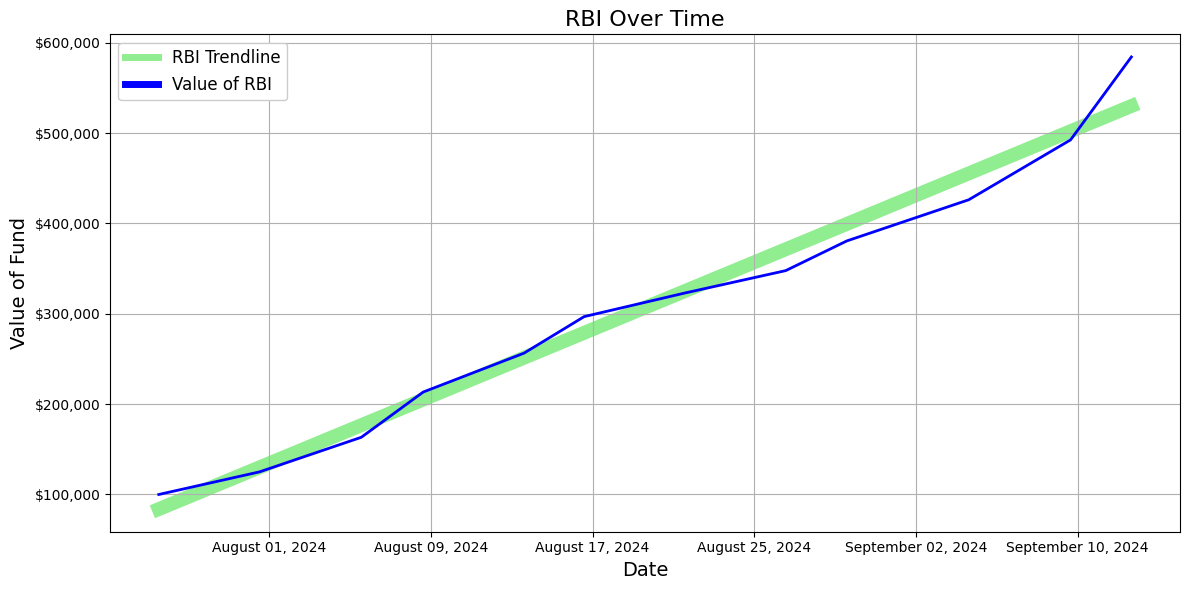

In [12]:
# Load the performance log
performance_log = pd.read_csv("Performance_Log.csv", parse_dates=["Action_Time"])

# Remove duplicate Action_Time entries
performance_log = performance_log.drop_duplicates(subset="Action_Time")

# Determine the number of points to plot
num_points = 12
indices = np.linspace(0, len(performance_log) - 1, num_points, dtype=int)

# Select the data at the calculated indices
selected_data = performance_log.iloc[indices]

# Plot the value of the fund over time
plt.figure(figsize=(12, 6))

# Calculate and plot the line of best fit (trend line) based on the selected data
x = date2num(selected_data["Action_Time"])
y = selected_data["Value_of_Fund"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Plot the Portfolio Trend line under the Value of Fund line
plt.plot(selected_data["Action_Time"], p(x), color='lightgreen', linewidth=10, label='RBI Trendline', zorder=1)

# Enhancing the chart
plt.plot(selected_data["Action_Time"], selected_data["Value_of_Fund"], color='blue', linewidth=2, label='Value of RBI', zorder=2)

plt.title('RBI Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value of Fund', fontsize=14)
plt.grid(True)

# Format the date on the x-axis to "Month Day, Year"
date_form = DateFormatter("%B %d, %Y")
plt.gca().xaxis.set_major_formatter(date_form)

# Format the y-axis with dollar signs and commas
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

# Set evenly spaced gridlines on x-axis
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=7))  # Adjust the number of gridlines on the x-axis

# Adding a legend with better display for the thick line
legend = plt.legend(loc='upper left', fontsize=12)
legend.get_frame().set_alpha(1)  # Make the legend background solid

# Adjust the thickness of the legend line
for legobj in legend.legendHandles:
    legobj.set_linewidth(5.0)

# Show the plot
plt.tight_layout()
plt.show()


In [13]:
# Directory containing the trade logs
trade_logs_dir = "Trade Logs"

# Initialize an empty list to store data for each ticker
summary_data = []

# Loop through each file in the trade logs directory
for filename in os.listdir(trade_logs_dir):
    if filename.endswith("_Trade_Log.csv"):
        ticker = filename.split('_')[0]
        filepath = os.path.join(trade_logs_dir, filename)
        
        # Read the trade log CSV file
        df = pd.read_csv(filepath)
        
        # Group by Trade_ID to pair buys and sells
        grouped = df.groupby('Trade_ID')
        
        # Initialize variables for counting trades and calculating returns
        total_trades = 0
        aggregate_log_return = 0
        
        for trade_id, group in grouped:
            if len(group) == 2:  # Ensure there's a buy and a sell
                buy_price = group.loc[group['Trade_Type'] == 'Buy', 'Action_Price'].values[0]
                sell_price = group.loc[group['Trade_Type'].str.contains('Sell'), 'Action_Price'].values[0]
                
                # Calculate the log return for this trade
                log_return = np.log(sell_price / buy_price)
                aggregate_log_return += log_return
                total_trades += 1
        
        if total_trades > 0:
            log_return_per_trade = aggregate_log_return / total_trades
        else:
            log_return_per_trade = 0
        
        # Append the data to the list
        summary_data.append([ticker, total_trades, round(aggregate_log_return, 3), round(log_return_per_trade, 3)])

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data, columns=['Ticker', 'Trade Count', 'Aggregate Log Return', 'Log Returns per Trade'])

# Sort the DataFrame by "Log Returns per Trade" in descending order
summary_df.sort_values(by='Log Returns per Trade', ascending=False, inplace=True)

# Save the summary DataFrame to a CSV file
summary_df.to_csv('Trading_Behavior.csv', index=False)

print("Trading Behavior CSV created successfully.")

Trading Behavior CSV created successfully.
